Import necessary modules:

In [124]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud

- Import 'csv' file

In [125]:
df = pd.read_csv("./Tweets.csv")

- Get first five records

In [126]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


- Filter out colums for further work

<h1>Exploratory data analysis</h1>

<h3> Most preferable airlines </h3>

- List of airlines

In [127]:
airlines = df['airline'].unique()

print("Airlines:", airlines)

Airlines: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


- Positive, neutral and negative <code>airline_sentiment</code> per <code>airline</code>

In [128]:
def get_airline_sentiment(df, airlines):
    positives = []
    negatives = []
    neutrals = []

    for airline in airlines:
        positive = df.query('@airline == airline and airline_sentiment == "positive"')['tweet_id'].count()
        negative = df.query('@airline == airline and airline_sentiment == "negative"')['tweet_id'].count()
        neutral = df.query('@airline == airline and airline_sentiment == "neutral"')['tweet_id'].count()
        
        positives.append(positive)
        negatives.append(negative)
        neutrals.append(neutral)
          
    return positives, negatives, neutrals
        

     
positives, negatives, neutrals = get_airline_sentiment(df, airlines)

sentiment_airlines_df = pd.DataFrame(index = airlines);
sentiment_airlines_df['neutrals'] = neutrals
sentiment_airlines_df['positives'] = positives
sentiment_airlines_df['negatives'] = negatives
sentiment_airlines_df

,neutrals,positives,negatives
Virgin America,171,152,181
United,697,492,2633
Southwest,664,570,1186
Delta,723,544,955
US Airways,381,269,2263
American,463,336,1960


- Positive, neutral and negative <code>airline_sentiment</code> per <code>airline</code> in percentage (%)

In [129]:
sentiment_airlines_percentage_df = pd.DataFrame(index = airlines);
sentiment_airlines_percentage_df['neutrals (%)'] = list(map(lambda n: n / sum(neutrals) * 100, neutrals))
sentiment_airlines_percentage_df['positives (%)'] = list(map(lambda n: n / sum(positives) * 100, positives))
sentiment_airlines_percentage_df['negatives (%)'] = list(map(lambda n: n / sum(negatives) * 100, negatives))
sentiment_airlines_percentage_df

,neutrals (%),positives (%),negatives (%)
Virgin America,5.517909,6.432501,1.972107
United,22.491126,20.820990,28.688167
Southwest,21.426267,24.121879,12.922205
Delta,23.330106,23.021583,10.405317
US Airways,12.294288,11.383834,24.656788
American,14.940303,14.219213,21.355415


<strong>According to this analysis, the most preferable airline is Southwest. Virgin America is the airline with the lowest negative feedbacks.</strong>

- Positive, neutral and negative <code>airline_sentiment</code> per <code>airline</code>

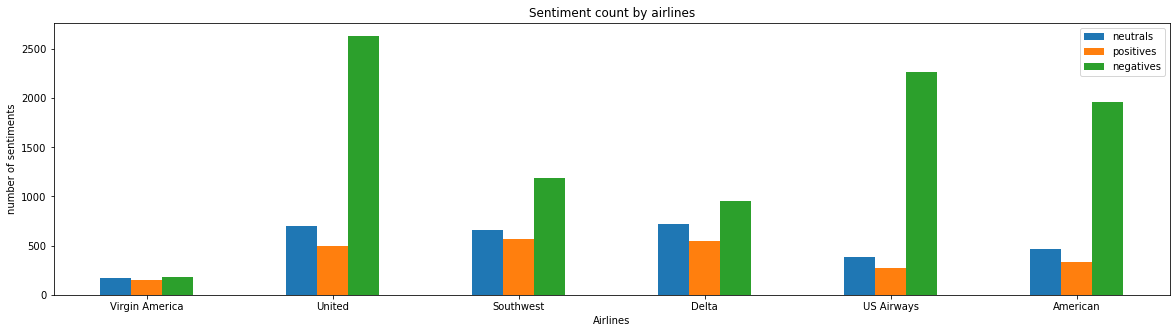

In [130]:
sentiment_airlines_df.plot.bar(rot=0, figsize=(20,5))

plt.title('Sentiment count by airlines')
plt.xlabel('Airlines')
plt.ylabel('number of sentiments')

plt.show()

In [131]:
sentiment_df = df[['airline_sentiment', 'text']].copy()

- Get first five records

In [132]:
sentiment_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


- Apply histogram (distribution of data) on <code>airline_sentiment</code> to check for potential class imbalance

<AxesSubplot:>

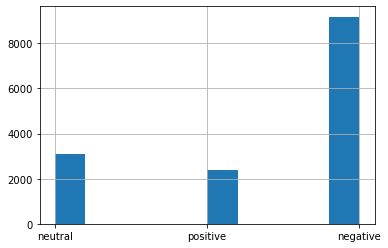

In [133]:
sentiment_df['airline_sentiment'].hist()

<strong style='color:red'>Class is imbalanced!</strong> Negative class overrepresented! <br/> <small>Note: Users may used social network to express dissatisfaction with a particular service.</small>

- Apply integer encoding

In [72]:
sentiment_encode = {
    'negative': 0, 
    'positive': 1, 
    'neutral': 2
}

In [73]:
sentiment_df['encoded_sentiment'] = sentiment_df['airline_sentiment'].map(sentiment_encode)

sentiment_df.head()

,airline_sentiment,text,encoded_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


- Split the data into two subrecords:
<ul>
    <li>train (30%)</li>
    <li>test (70%)</li>
</ul>

In [74]:
df_train, df_test = train_test_split(sentiment_df, train_size = 0.30)

print(f'Number of train samples are: {len(df_train.index)}.\nNumber of test samles are: {len(df_test.index)}.')

Number of train samples are: 4392.
Number of test samles are: 10248.


- Get the last five records

In [75]:
df_train.tail()

,airline_sentiment,text,encoded_sentiment
6596,negative,@SouthwestAir Your onboard wifi is so bad it's...,0
13654,negative,@AmericanAir highly disappointed in the baggag...,0
10942,positive,@USAirways Thks US #1786 2/19 PHL to FLL. Over...,1
2866,positive,@united On the plane but thanks! Maybe don't l...,1
10731,negative,@USAirways I know some folks have to use your ...,0


- Get the last five records

In [76]:
df_test.tail()

,airline_sentiment,text,encoded_sentiment
10612,negative,All followers please note that @USAirways is n...,0
2820,negative,@united Terribly disappointed. Confirmed reser...,0
6846,neutral,"@JetBlue Hi there, any rough idea of when Janu...",2
4961,positive,@SouthwestAir Mad love http://t.co/4ojrSDWPkK...,1
11507,neutral,"@USAirways No, this is a systemic problem. Mai...",2


- Create TD IDF vectorizer object (transforms the text into a usable vector)


<small><code>max_features</code> limits the vocabulary size of the model to 2000</small>

In [77]:
vectorizer = TfidfVectorizer(max_features = 2000)
vectorizer

TfidfVectorizer(max_features=2000)

- Fit vectorizer to the training data and transform it into <code>X_train</code>

In [78]:
X_train = vectorizer.fit_transform(df_train['text'])
X_train

<4392x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 63686 stored elements in Compressed Sparse Row format>

- Transform the test data into <code>X_test</code>

In [79]:
X_test = vectorizer.transform(df_test['text'])
X_test

<10248x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 144915 stored elements in Compressed Sparse Row format>

- Assign <code>Y_train</code> and <code>Y_test</code> to <code>encoded_sentiment</code> from previously integer encoded <code>airline_sentiment</code>

In [80]:
Y_train = df_train['encoded_sentiment']
Y_test = df_test['encoded_sentiment']

- print <code>df_train</code> data frame

In [81]:
df_train

,airline_sentiment,text,encoded_sentiment
11434,negative,@USAirways would you consider honoring the ori...,0
9634,negative,@USAirways pls get me back to Tallahassee:( no...,0
1567,negative,@united might possibly have the worst service ...,0
2663,negative,@united Thanks for nothing. Next time I'll bri...,0
8224,positive,@JetBlue yes thankfully! Catering just got her...,1
...,...,...,...
6596,negative,@SouthwestAir Your onboard wifi is so bad it's...,0
13654,negative,@AmericanAir highly disappointed in the baggag...,0
10942,positive,@USAirways Thks US #1786 2/19 PHL to FLL. Over...,1
2866,positive,@united On the plane but thanks! Maybe don't l...,1


- print <code>df_test</code> data frame

In [82]:
df_test

,airline_sentiment,text,encoded_sentiment
11453,negative,@USAirways they said because there was no meal...,0
965,negative,@united #albanyairport delayed departure to ch...,0
5774,positive,@SouthwestAir Hi! I ❤️ your company and fly al...,1
9838,negative,@USAirways @AmericanAir will one of you please...,0
10590,negative,@USAirways flight 813 DCA to CLT stuck waiting...,0
...,...,...,...
10612,negative,All followers please note that @USAirways is n...,0
2820,negative,@united Terribly disappointed. Confirmed reser...,0
6846,neutral,"@JetBlue Hi there, any rough idea of when Janu...",2
4961,positive,@SouthwestAir Mad love http://t.co/4ojrSDWPkK...,1


- Build a logistic reggression instace 

<small><code>max_iter</code> number of training processes taken to converge with the default values</small>

In [83]:
model = LogisticRegression(max_iter = 500)

- Fit the both train sets to the model

In [84]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

- Print train set accuracy

In [85]:
print("Train acc:", model.score(X_train, Y_train))

Train acc: 0.8526867030965392


- Print test set accuracy

In [86]:
print("Test acc:", model.score(X_test, Y_test))

Test acc: 0.779664324746292


<small style='color:red'>Note: Both results cannot be interpreted in isolation since there are imbalanced classes</small>

- Check the AUC (infer the class probabilities)

In [87]:
Pr_train = model.predict_proba(X_train)
Pr_test = model.predict_proba(X_test)

- Print train AUC

In [88]:
print("Train AUC:", roc_auc_score(Y_train, Pr_train, multi_class = 'ovo'))

Train AUC: 0.9559508474794239


- Print test AUC

In [89]:
print("Test acc:", roc_auc_score(Y_test, Pr_test, multi_class = 'ovo'))

Test acc: 0.8764936196260439


- Get the class labels predictions

In [90]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

- Call the confusion matrix function

In [91]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.97595628, 0.00364299, 0.02040073],
       [0.23695346, 0.69816643, 0.06488011],
       [0.35714286, 0.03411514, 0.608742  ]])

- Plot the confusion matrix

In [92]:
classes = ['negative', 'positive', 'neutral'] 

Text(33.0, 0.5, 'Target')

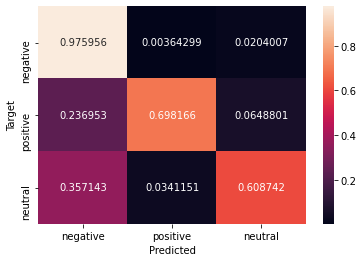

In [93]:
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

<ul>
    <li>Model do very well on negative class</li>
    <li>For positive class we get around 70 %</li>
    <li>When we do not predict the positive class corectly, we actually predict negative rather than neutral (it seems that there is a little chance of confusing positive tweets with neutral tweets)</li>
    <li>Predicting neutral is the worst. If we predict wrong neutral, it will be rather negative than positive</li>
</ul>

<small>Note: Model is biased towards the negative class as it is overrepsented class</small>

In [94]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
cm_test

array([[0.94730297, 0.01321312, 0.03948391],
       [0.32648126, 0.53990326, 0.13361548],
       [0.47987043, 0.0559926 , 0.46413697]])

Text(33.0, 0.5, 'Target')

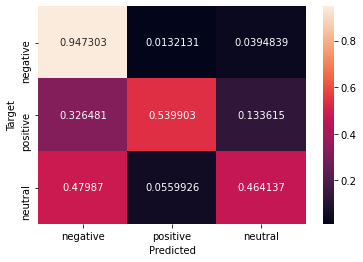

In [95]:
df_cm = pd.DataFrame(cm_test, index=classes, columns=classes)

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_xlabel("Predicted")
ax.set_ylabel("Target")

<small style='color:red'>Performance is a bit worse! It's biased towards negative class.</small>

<h3>Train model without neutral class</h3>

- Take the samples that are classified as positive and negative

In [96]:
binary_target_list = [sentiment_encode['positive'], sentiment_encode['negative']]                    
binary_target_list        

[1, 0]

- Filter the rows with the <code>encoded_sentiment</code> equal to 2

In [97]:
df_b_train = df_train[df_train['encoded_sentiment'] != 2]
df_b_test = df_test[df_test['encoded_sentiment'] != 2]

print("Number of neutral airline_sentiment:", df_b_train.query('airline_sentiment == "neutral"')['airline_sentiment'].count())
print("Number of neutral airline_sentiment:", df_b_test.query('airline_sentiment == "neutral"')['airline_sentiment'].count())

Number of neutral airline_sentiment: 0
Number of neutral airline_sentiment: 0


- Print last five records

In [98]:
df_b_train.tail()

,airline_sentiment,text,encoded_sentiment
6596,negative,@SouthwestAir Your onboard wifi is so bad it's...,0
13654,negative,@AmericanAir highly disappointed in the baggag...,0
10942,positive,@USAirways Thks US #1786 2/19 PHL to FLL. Over...,1
2866,positive,@united On the plane but thanks! Maybe don't l...,1
10731,negative,@USAirways I know some folks have to use your ...,0


- Convert dataset into TD IDF vectorizer object

In [99]:
X_train = vectorizer.fit_transform(df_b_train["text"])
X_test = vectorizer.fit_transform(df_b_test["text"])

- Get the <code>encoded_sentiment</code> classes and obtain <code>Y_train</code> and <code>Y_test</code>

In [100]:
Y_train = df_b_train['encoded_sentiment']
Y_test = df_b_test['encoded_sentiment']

- Train a new model on binary dataset

In [101]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

- Print the binary accuracy

In [102]:
print("Train acc:", model.score(X_train, Y_train))
print("Test acc:", model.score(X_test, Y_test))

Train acc: 0.917486971627099
Test acc: 0.7895387659206133


- Compute the AUC

<small>Because we have binary classes, we only need one complement index 1 from the probabilities</small>

In [103]:
Pr_train = model.predict_proba(X_train)[:, 1]
Pr_test = model.predict_proba(X_test)[:, 1]

- Print the binary accuracy

In [104]:
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

Train AUC: 0.9797919540850014
Test AUC: 0.4429255533410989


- Obtain a weights from the trained model

In [105]:
model.coef_

array([[-0.18885046, -0.18586426, -0.08895383, ...,  0.23569296,
         0.37591575, -0.24746794]])

- Plot the histogram of the weights

<small></small>

(array([  2.,   0.,   0.,   0.,   2.,   9.,  13.,  22.,  32.,  96., 355.,
        838., 344., 143.,  68.,  36.,  16.,  10.,   1.,   1.,   1.,   2.,
          3.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([-2.84204983, -2.60174561, -2.36144139, -2.12113716, -1.88083294,
        -1.64052872, -1.40022449, -1.15992027, -0.91961605, -0.67931182,
        -0.4390076 , -0.19870338,  0.04160084,  0.28190507,  0.52220929,
         0.76251351,  1.00281774,  1.24312196,  1.48342618,  1.72373041,
         1.96403463,  2.20433885,  2.44464307,  2.6849473 ,  2.92525152,
         3.16555574,  3.40585997,  3.64616419,  3.88646841,  4.12677264,
         4.36707686,  4.60738108,  4.8476853 ,  5.08798953,  5.32829375,
         5.56859797,  5.8089022 ,  6.04920642,  6.28951064,  6.52981487,
         6.77011909]),
 <BarContainer object of 40 artists>)

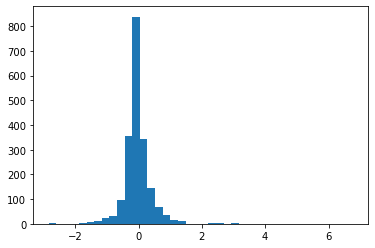

In [106]:
plt.hist(model.coef_[0], bins = 40)

- Obtain the words to index mapping because we won't know which words correspond to which input

In [107]:
word_index_map = vectorizer.vocabulary_
word_index_map 

{'usairways': 1866,
 'they': 1741,
 'said': 1511,
 'because': 231,
 'there': 1739,
 'was': 1908,
 'no': 1208,
 'meal': 1116,
 'on': 1246,
 'my': 1185,
 'flight': 726,
 'would': 1975,
 'not': 1216,
 'what': 1935,
 'airline': 117,
 'food': 754,
 'anymore': 159,
 'update': 1856,
 'in': 943,
 'policy': 1352,
 'united': 1846,
 'delayed': 500,
 'departure': 514,
 'to': 1772,
 'check': 355,
 'bags': 220,
 'at': 191,
 'gate': 795,
 'space': 1633,
 'filled': 709,
 'and': 146,
 'walk': 1899,
 'open': 1254,
 'delay': 499,
 'southwestair': 1631,
 'hi': 884,
 'your': 1995,
 'company': 404,
 'fly': 745,
 'all': 124,
 'the': 1735,
 'time': 1764,
 'if': 932,
 'you': 1994,
 'could': 449,
 'please': 1341,
 'share': 1563,
 'this': 1748,
 'link': 1050,
 'amp': 144,
 'read': 1419,
 'http': 917,
 'co': 385,
 'americanair': 141,
 'will': 1948,
 'one': 1249,
 'of': 1231,
 'answer': 154,
 'phone': 1318,
 'dca': 492,
 'clt': 380,
 'stuck': 1673,
 'waiting': 1897,
 'missing': 1158,
 'flt': 743,
 'hope': 899,
 'c

- Define the most extreme words for each class (find the words with the largest magnitudes of weights)

<small style='color:red'>Note: Words that have largest impact on the output.</small>
<small>

<p>There is no much words with the weight larger than two we'll try with different tresholds:</p>
<ul>
    <li>2</li>
    <li>1.5</li>
    <li>1.8</li>
</ul>
</small>

In [108]:
tresholds = [2, 1.5, 1.8]

- Print the most positive words

In [109]:
print("Most positive words:")

most_positive_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > tresholds[0]:
        most_positive_words[word] = weight
        print(word, weight)

Most positive words:
amp 3.1293147955862297
beyond 2.4567690431826392
losing 2.4835654187214122
bad 2.198728789623176
glad 3.670438948706921
sunday 6.770119088457509
intl 3.0908592006543087
updates 2.220815371613413
taxi 2.8461959702584565
suitcase 6.081959549942102
gift 2.465708992638931
side 2.2265739990818973


In [110]:
print("Most positive words:")

most_positive_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > tresholds[1]:
        most_positive_words[word] = weight
        print(word, weight)

Most positive words:
amp 3.1293147955862297
beyond 2.4567690431826392
losing 2.4835654187214122
bad 2.198728789623176
glad 3.670438948706921
sunday 6.770119088457509
intl 3.0908592006543087
americanairlines 1.6577325854404168
updates 2.220815371613413
taxi 2.8461959702584565
suitcase 6.081959549942102
wasted 1.8558972715539899
gift 2.465708992638931
side 2.2265739990818973


In [111]:
print("Most positive words:")

most_positive_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > tresholds[2]:
        most_positive_words[word] = weight
        print(word, weight)

Most positive words:
amp 3.1293147955862297
beyond 2.4567690431826392
losing 2.4835654187214122
bad 2.198728789623176
glad 3.670438948706921
sunday 6.770119088457509
intl 3.0908592006543087
updates 2.220815371613413
taxi 2.8461959702584565
suitcase 6.081959549942102
wasted 1.8558972715539899
gift 2.465708992638931
side 2.2265739990818973


<small>Some words may be the names of the airlines which means that these are associated with positive feedback!</small>

In [112]:
most_positive_words_df = pd.DataFrame.from_dict(most_positive_words, orient='index', columns=['weight'])

most_positive_words_df

,weight
amp,3.129315
beyond,2.456769
losing,2.483565
bad,2.198729
glad,3.670439
sunday,6.770119
intl,3.090859
updates,2.220815
taxi,2.846196
suitcase,6.081960


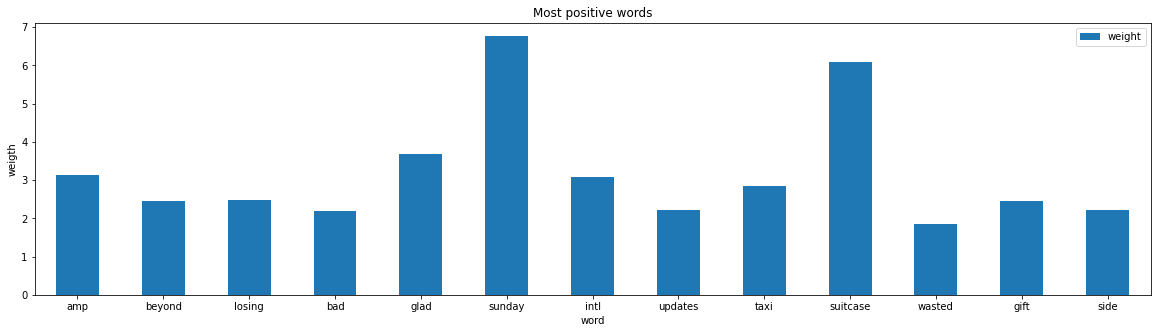

In [113]:
most_positive_words_df.plot.bar(rot=0, figsize=(20,5))

plt.title('Most positive words')
plt.xlabel('word')
plt.ylabel('weigth')

plt.show()

Wordcloud for most positive words


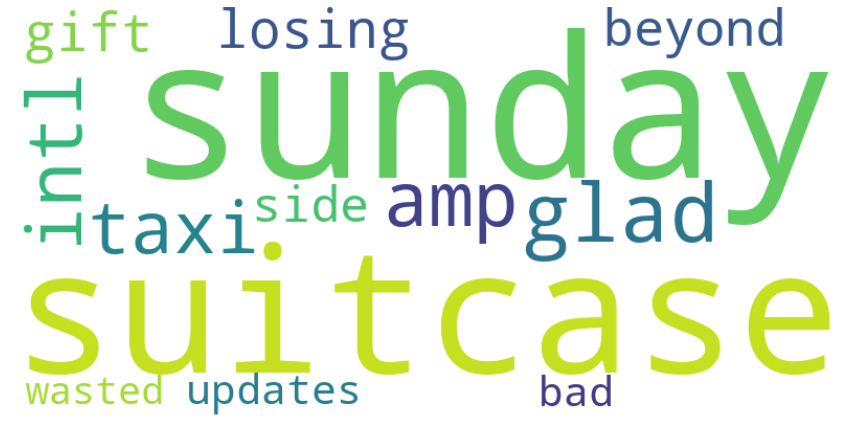

In [114]:
print("Wordcloud for most positive words")

positive_wordcloud = WordCloud(background_color="white", width=800, height=400)
positive_wordcloud.generate_from_frequencies(most_positive_words)
plt.figure(figsize=(15,10))
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- Print the most negative words

In [115]:
print("Most negative words:")

most_negative_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < - tresholds[0]:
        most_negative_words[word] = weight
        print(word, weight)

Most negative words:
nah -2.642376838357089
nearly -2.8420498314743936


In [116]:
print("Most negative words:")

most_negative_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < - tresholds[2]:
        most_negative_words[word] = weight
        print(word, weight)

Most negative words:
nah -2.642376838357089
nearly -2.8420498314743936


In [117]:
print("Most negative words:")

most_negative_words = {}

for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < - tresholds[1]:
        most_negative_words[word] = weight
        print(word, weight)

Most negative words:
welcome -1.547423732789267
different -1.5070643518687898
nah -2.642376838357089
wonder -1.5662233091130773
unavailable -1.5377175575115585
hence -1.7242087386862028
calls -1.5854387034934971
honest -1.7182204630046793
incredible -1.6000046427102281
damn -1.5314282817185614
nearly -2.8420498314743936


In [118]:
most_negative_words_df = pd.DataFrame.from_dict(most_negative_words, orient='index', columns=['weight'])

most_negative_words_df

,weight
welcome,-1.547424
different,-1.507064
nah,-2.642377
wonder,-1.566223
unavailable,-1.537718
hence,-1.724209
calls,-1.585439
honest,-1.718220
incredible,-1.600005
damn,-1.531428


<small>Words like: hours, now, and will are words that have low weight. That means that (unfulfilled) promises are time-consuming, and one of the most relevant factors of good service is the time in which the service is delivered.</small>

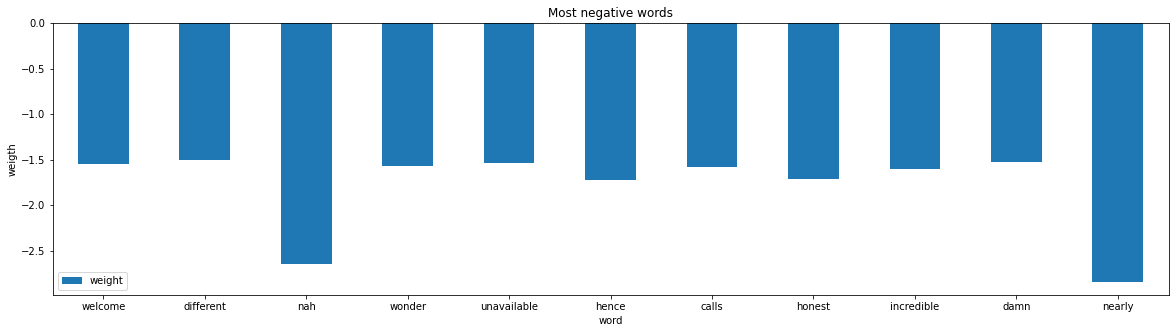

In [119]:
most_negative_words_df.plot.bar(rot=0, figsize=(20,5))

plt.title('Most negative words')
plt.xlabel('word')
plt.ylabel('weigth')

plt.show()

Wordcloud for most negative words


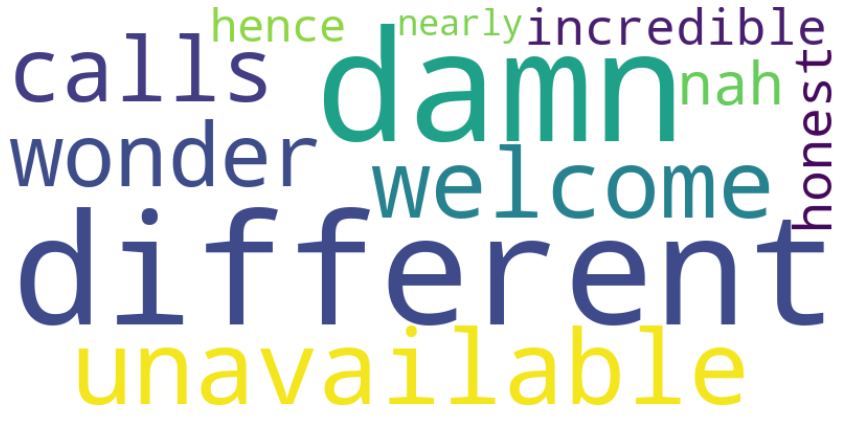

In [120]:
print("Wordcloud for most negative words")

negative_wordcloud = WordCloud(background_color="white", width=800, height=400)
negative_wordcloud.generate_from_frequencies(most_negative_words)
plt.figure(figsize=(15,10))
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- Filter out stopwords

In [121]:
stop = stopwords.words('english')

most_positive_words_without_stop_words = [word for word in most_positive_words_df.index if word not in stopwords.words('english')]
most_negative_words_without_stop_words = [word for word in most_negative_words_df.index if word not in stopwords.words('english')]

print("Before:", len(most_positive_words), len(most_negative_words))
print("After:", len(most_positive_words_without_stop_words), len(most_negative_words_without_stop_words))



Before: 13 11
After: 13 11


In [122]:
filtered_df = pd.DataFrame();
filtered_df['State'] = ["Before", "After"]
filtered_df['Positive'] = [len(most_positive_words), len(most_negative_words)]
filtered_df['Negative'] = [len(most_positive_words_without_stop_words), len(most_negative_words_without_stop_words)]

filtered_df

,State,Positive,Negative
0,Before,13,13
1,After,11,11
